In [1]:
import math
import random
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [2]:
btc_data = pd.read_csv('btc_data.csv')

* BTC mined per 1 Th/Day: 0.00001519 (see [here](https://www.cryptocompare.com/mining/calculator/btc?HashingPower=1&HashingUnit=TH%2Fs&PowerConsumption=1293&CostPerkWh=0.12&MiningPoolFee=1))
* Collateral ratio: 150%
* Contract duration: 30 days
* BTC collateral requirements per 1 Th/s: BTC_day * duration * col_ratio
* Initial price assumption = BTC_day * duration * BTC_price. For simplicity we want the protocol at launch to show price that equals to sum of 30 day BTC payoff converted to USD. Tis will help us calculate the right K - bonding curve constant.
* Initial USD reserve: $100K
* price = usd_reserve / btc_reserve => btc_reserve = usd_reserve / price
* curve: usd_reserve * btc_reserve = K => K = usd_reserve * usd_reserve / price

Definitions:
\begin{align}
& R_{usd}\text{ - USD reserve} \\
& R_{btc}\text{ - BTC reserve} \\
& ind\text{ - hashrate index. Represents BTC payoffs for 1Th/Day} \\
& R_{hr}\text{ - hashrate reserve (how much mining hashrate we can simulate based on }R_{btc}\text{ and }ind \text{)} \\
& D\text{ - Duration of contract (30 days)} \\
& f_c\text{ - collateral factor (150%)} \\
& p\text{ - 1Th contract price}
\end{align}

Formulas:
\begin{align}
& R_{btc} \cdot R_{usd} = K \text{- constant-product bonding curve}\\
& (R_{btc} - \Delta_{btc})(R_{usd} + \Delta_{usd}) = R_{btc} R_{usd} \\
& R_{hr} = \frac{R_{btc}}{ind \cdot D \cdot f_c} \\
& p = \frac{R_{usd}}{R_{hr}} = \frac{R_{usd} \cdot ind \cdot D \cdot f_c}{R_{btc}} \\
\end{align}

Open questions:
* Index jumps. This creates an arb that drains the pool
* Miners want to input a fixed price (simple UX)
* Implementation complexity - how much more complex this is vs an off-chain order book?



In [3]:
# Initial parameters

col_factor = 1.5 # 150%
duration = 30 # days

init_BTC_price = btc_data.iloc[0]['PriceUSD'] # 6327.14
init_index = btc_data.iloc[0]['Index'] # 0.00001519
# init_BTC_price = 6327.14
# init_index = 0.00001519

init_usd_reserve = 100000.0 # let's say we deposit $100K initially
target_price = init_index * duration * init_BTC_price # that's our target price for protocol launch
print(("Target 1 Th/s price: {:,.2f} USD".format(target_price)))
init_hr_reserve = init_usd_reserve / target_price
print(("Initial Hashrate reserve: {:,.2f} ({:,.2f} USD)".format(init_hr_reserve, init_hr_reserve * target_price)))
init_btc_reserve = init_hr_reserve * init_index * duration * col_factor
print(("Initial BTC reserve: {:,.2f} BTC ({:,.2f} USD)".format(init_btc_reserve, init_btc_reserve * init_BTC_price)))
K = init_btc_reserve * init_usd_reserve
print(("Found K: {:,}".format(K)))

Target 1 Th/s price: 63.50 USD
Initial Hashrate reserve: 1,574.71 (100,000.00 USD)
Initial BTC reserve: 345.08 BTC (150,000.00 USD)
Found K: 34,508,302.1895446


In [13]:
# Model

tf.compat.v1.reset_default_graph()

data = tf.convert_to_tensor(btc_data['Index'])
index = tf.compat.v1.placeholder(tf.float64, name='index') # index (daily payoffs in BTC)
btc_price = tf.compat.v1.placeholder(tf.float64, name='btc_price')
btc_reserve = tf.Variable(init_btc_reserve)
hr_reserve = btc_reserve / (index * duration * col_factor) # hashrate reserve fluctuates based on the index
usd_reserve = K / btc_reserve
price = usd_reserve / hr_reserve
init_op = tf.compat.v1.initialize_all_variables()

def get_total_price(size):
    # Make sure we don't allow removing entire hr reserve
    new_hr_reserve = tf.math.maximum(tf.constant(10.0, dtype=tf.float64), hr_reserve - size)
    new_btc_reserve = new_hr_reserve * index * duration * col_factor
    new_usd_reserve = K / new_btc_reserve
    return new_usd_reserve / new_hr_reserve

def trade(size):
    # Make sure we don't allow removing entire hr reserve
    new_hr_reserve = tf.math.maximum(tf.constant(10.0, dtype=tf.float64), hr_reserve - size)
    new_btc_reserve = new_hr_reserve * index * duration * col_factor
    return btc_reserve.assign(new_btc_reserve)
    
def size_for_price(target_price):
    current_price = price
    current_hr_reserve = hr_reserve
    target_hr_reserve = tf.math.sqrt(current_price * (current_hr_reserve ** 2) / target_price)
    
    return current_hr_reserve - target_hr_reserve    

In [14]:
def do_random_trades():
    rational_price = index * duration * btc_price
    actual_price = rational_price * random.uniform(0.0, 2.0) # people are irrational and do weird shit
    daily_net_size = size_for_price(actual_price) # a trade required to move the price to "actual_price"
    return trade(daily_net_size)
    

dict = {}
results = pd.DataFrame([], columns = ['time', 'price' , 'btc_reserve', 'usd_reserve' , 'hr_reserve', 'index', 'usd_change', 'btc_change'])
with tf.compat.v1.Session() as sess:
    sess.run(init_op)
    # sess.graph.finalize()
    # Go through each day and do some random trades within some rational bounds
    trade_op = do_random_trades()
    for i, row in btc_data.iterrows():
        print('Processing row [%d]\r'%i, end="")
        feed_dict = {index: row['Index'], btc_price: row['PriceUSD']}
        _, cur_btc_reserve, cur_usd_reserve, cur_hr_reserve, cur_price = sess.run([trade_op, btc_reserve, usd_reserve, hr_reserve, price], feed_dict=feed_dict)
        dict[i] = {
            'time': row['time'], 
            'price': cur_price,
            'btc_price': row['PriceUSD'],
            'btc_reserve': cur_btc_reserve,
            'usd_reserve': cur_usd_reserve,
            'hr_reserve': cur_hr_reserve,
            'index': row['Index'],
            'usd_change': cur_usd_reserve - dict[i - 1]['usd_reserve'] if i > 0 else 0,
            'btc_change': cur_btc_reserve - dict[i - 1]['btc_reserve'] if i > 0 else 0,
            'hr_change': cur_hr_reserve - dict[i - 1]['hr_reserve'] if i > 0 else 0
        }
res_df = pd.DataFrame.from_dict(dict, orient='index')

In [15]:
res_df

,time,price,btc_price,btc_reserve,usd_reserve,hr_reserve,index,usd_change,btc_change,hr_change
0,2016-01-01T00:00:00.000Z,63.503718,434.678006,345.083022,100000.000000,1574.710942,0.004870,0.000000,0.000000,0.000000
1,2016-01-02T00:00:00.000Z,46.629867,434.439877,403.254556,85574.488163,1835.186193,0.004883,-14425.511837,58.171534,260.475251
2,2016-01-03T00:00:00.000Z,46.518128,430.136180,405.377956,85551.044871,1839.090441,0.004874,-23.443293,2.123401,3.904248
3,2016-01-04T00:00:00.000Z,46.055623,433.448971,403.825861,85126.242492,1848.335489,0.004874,-424.802379,-1.552095,9.245048
4,2016-01-05T00:00:00.000Z,46.482654,432.669503,404.189450,85453.423244,1838.393820,0.004881,327.180751,0.363589,-9.941670
...,...,...,...,...,...,...,...,...,...,...
1536,2020-03-16T00:00:00.000Z,1.862734,5012.927388,114.851590,300459.941893,161300.484441,0.000016,6044.593311,-2.357999,-5428.543503
1537,2020-03-17T00:00:00.000Z,1.741116,5416.754711,118.745568,290607.075444,166908.524855,0.000016,-9852.866449,3.893977,5608.040415
1538,2020-03-18T00:00:00.000Z,1.895346,5392.487836,114.233512,302085.626604,159382.848148,0.000016,11478.551159,-4.512055,-7525.676707
1539,2020-03-19T00:00:00.000Z,1.892257,6203.551632,114.490257,301408.200427,159285.029742,0.000016,-677.426177,0.256744,-97.818406


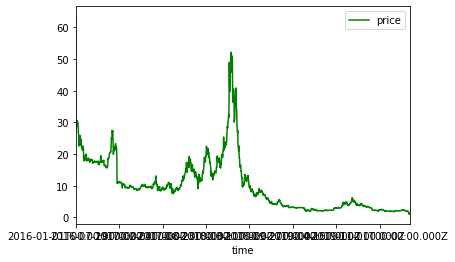

In [7]:
res_df.plot(kind='line',x='time',y='price',color='green')
plt.show()

In [8]:
res_df.head(50)

,time,price,btc_price,btc_reserve,usd_reserve,hr_reserve,index,usd_change,btc_change,hr_change
0,2016-01-01T00:00:00.000Z,63.503718,434.678006,345.083022,100000.000000,1574.710942,0.004870,0.000000,0.000000,0.000000
1,2016-01-02T00:00:00.000Z,28.983103,434.439877,511.492099,67465.953481,2327.768468,0.004883,-32534.046519,166.409078,753.057526
2,2016-01-03T00:00:00.000Z,28.913651,430.136180,514.185442,67447.471055,2332.720655,0.004874,-18.482425,2.693342,4.952187
3,2016-01-04T00:00:00.000Z,28.626178,433.448971,512.216749,67112.561690,2344.447166,0.004874,-334.909365,-1.968693,11.726511
4,2016-01-05T00:00:00.000Z,28.891602,432.669503,512.216749,67370.507275,2331.837053,0.004881,257.945584,0.000000,-12.610113
5,2016-01-06T00:00:00.000Z,28.852833,430.677870,512.677929,67309.904042,2332.869851,0.004884,-60.603233,0.461180,1.032797
6,2016-01-07T00:00:00.000Z,28.756058,459.208940,513.861979,67154.807317,2335.327321,0.004890,-155.096725,1.184050,2.457470
7,2016-01-08T00:00:00.000Z,30.583096,454.134424,497.642652,69343.538054,2267.381214,0.004877,2188.730737,-16.219327,-67.946107
8,2016-01-09T00:00:00.000Z,30.269345,449.845216,500.415268,68959.331182,2278.190370,0.004881,-384.206872,2.772616,10.809156
9,2016-01-10T00:00:00.000Z,29.923235,448.580216,502.795301,68632.905150,2293.632505,0.004871,-326.426032,2.380033,15.442134


In [ ]:
with tf.compat.v1.Session() as sess:
    sess.run(init_op)
    print('(before) price: {}'.format(price.eval()))
    trade(1000, sess)
    print('(after) price: {}'.format(price.eval()))
    print('buy_arb_oppty: {}'.format(buy_arb_oppty()))
    print('sell_arb_oppty: {}'.format(sell_arb_oppty()))